<a href="https://colab.research.google.com/github/shardulOG/Intern-Task-1/blob/main/Machine_Learning_Intern_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


###Task 1 from "StablX Digital Marketing Agency"
Problem 1: Design 
Resource:  Design an image processing system that takes an image of a Television with white background and adds a relevant background with a bokeh effect. 

The background image in this can be taken from pexels.com open API or Google.  


Input: Television Image with White Background

Output:
Television Image with Blur Background 


For Example:
If this is the input image: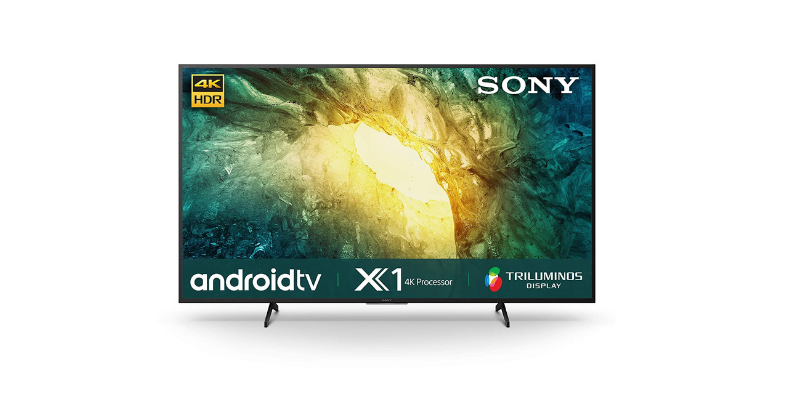




The output image must contain a blur background:
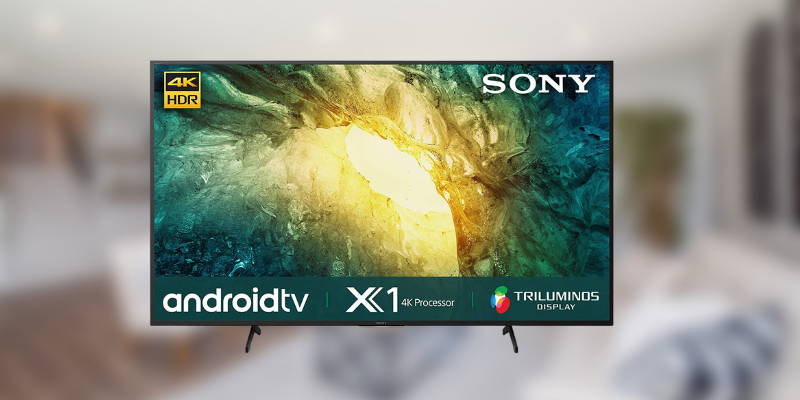 

[LINK of dataset and problem defination ](https://docs.google.com/document/d/1DozqjnCWAchpkyj38hwn8BOuZ1vBHS_PfQ1_2_ygdEY/edit#)

###IMPORTING REQUIRED LIBRARIES

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG

In [2]:

%tensorflow_version 1.x
import tensorflow as tf   

TensorFlow 1.x selected.


###USING DEEP LAB MODEL FOR TV IDENTIFICATION AND IDENTIFYING REQUIRED CONTOUR and performing semantic segmentation:
The deep lab model is taken from :[Deep Lab Demo](https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

**About deep lab and semantic segmentaton:**
**Semantic segmentation** is the process of associating each pixel of an image with a class label, (such as flower, person, road, sky, ocean,tv or car). This detailed pixel level understanding is critical for many AI based systems to allow them overall understanding of the scene.

**About Deep Lab:**
The Deeplab V3 model combines several powerful concepts in computer vision deep learning —
1. Spatial Pyramid pooling — Spatial pyramid architectures help with information in the image at different scales i.e small objects like cats and bigger objects like cars. 

2. Encoder-Decoder architectures — This has become a very popular architecture for a variety of tasks in computer vision and NLP.

3. Atrous convolutions — DeepLab uses atrous convolutions. Atrous convolutions require a parameter called rate which is used to explicitly control the effective field of view of the convolution. 

Reference:[Deep lab Segmentaion Blog](https://deeplearninganalytics.org/semantic-segmentation/)

In [3]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  # INPUT_SIZE = 1024
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(width, height)
    print("Resize Ratio - {}".format(resize_ratio))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    print(target_size)
    # target_size = (width, height)
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### OUR NEXT TASK IS TO CREATE A FUNCTION TO PERFORM IMAGE SEGMENTATION 
The function uses any of these pre-trained models:
**mobilenetv2** and **xception_coco** :
**mobilenetv2** proved to show better results with the problem defination

In [4]:

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


`run_visualization()`:function that helps to undesrtands how semantic segmentation works

In [5]:
def run_visualization():
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image')
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)
  return resized_im, seg_map

##Here I am going to use a TV image with a white background as an input image and perform the following steps:



1.   Run an pretarined/custom algorithm and detect if the input image is a television
2.   Run an pretarined/custom algorithm to see if we can really change the background (Images having background anything other than white should not be processed with an error “Background cannot be changed as it already have one”)
3.  Remove white background from input image
4.  Put an Image background 
5.  Add blur/bokeh in the background image to make it look good
6.  Test if the image looks realistic







# **1.Importing an image, resizing it and running deep lab on the image**

running deeplab on image
370 278
Resize Ratio - 1.3864864864864865
(513, 385)


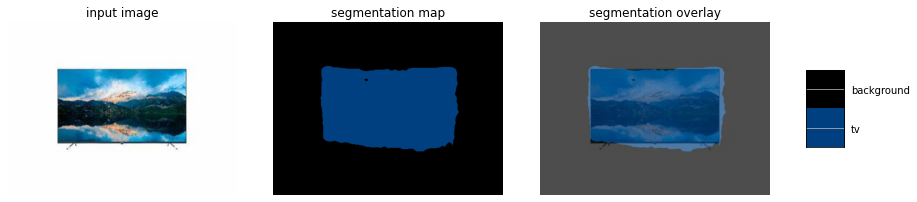

In [6]:

IMAGE_NAME = '/content/drive/MyDrive/Untitled folder/OIP (2).jfif'
resized_im, seg_map = run_visualization()

This are the list of objects that deeplab model can identify

In [7]:
LABEL_NAMES

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tv'], dtype='<U11')

For TV the index is 20

In [8]:

LABEL_NAMES[20]

'tv'

1B: Convert PIL Image to Numpy

In [9]:
print(type(resized_im))  ##display type of image
numpy_image = np.array(resized_im) #converting PIL image to a numpy array


<class 'PIL.Image.Image'>


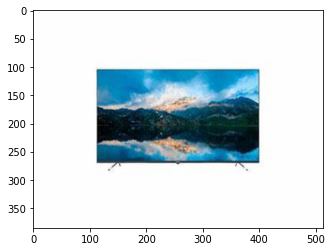

In [10]:

plt.imshow(numpy_image) #show converted image

# **2.Run an pretarined/custom algorithm to see if we can really change the background (Images having background anything other than white should not be processed with an error “Background cannot be changed as it already have one”)**

Function to detect if image has a white background or not

In [11]:
def image_white_background_detector(imgs_path):
  """
  Function to detect if image has a white background or not
  """
  from PIL import Image
  img = Image.open(imgs_path)  #take a path of an image as argument 
  img = np.array(img) #convert into numpy array

  boolean_array=img[0][0]==(255) #check whether the 0th pixel of image is 255(which is white color)

  check= [True, True,  True,  True] #generate a check list
  label_list=list(boolean_array) #convert boolean values into a list

  if check==label_list: 
    print("Image has a white background...")
    print("Therefore lets proceed with removing it")
  else:
    print("Background cannot be changed as it already have one")

Checking our function with this image:
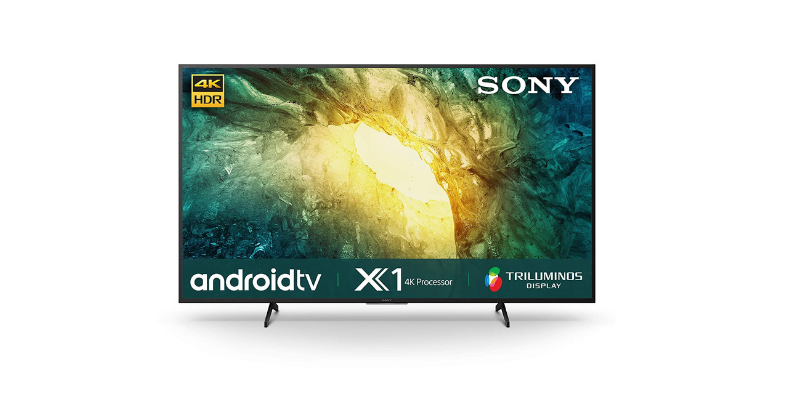

In [12]:
image_white_background_detector(imgs_path="/content/drive/MyDrive/Untitled folder/1.png")

Image has a white background...
Therefore lets proceed with removing it


Checking our function with this image:

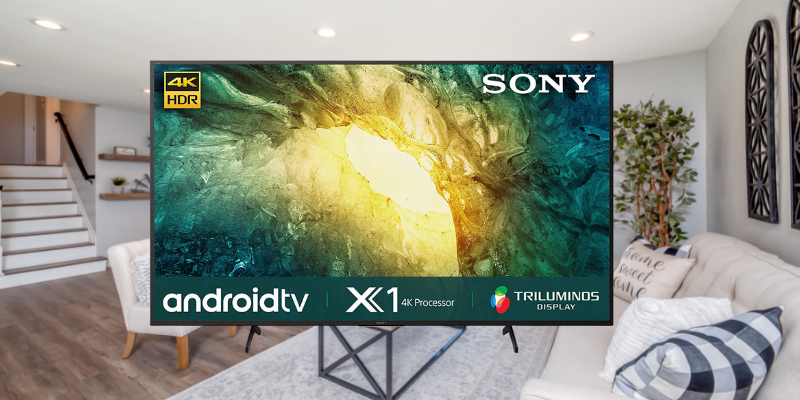

In [13]:
image_white_background_detector(imgs_path="/content/drive/MyDrive/Untitled folder/2.png")

Background cannot be changed as it already have one


# **3.Remove white background from input image**

3A:Seperate TV & Not TV classes using Segmap

In [17]:

tv_no_tv_mapping = deepcopy(numpy_image) 
#seg_map appears to have 2 unique colors black and white
tv_no_tv_mapping[seg_map != 20] = 0  #places which don't have tv will be black
tv_no_tv_mapping[seg_map == 20] = 255 #places which have tv will be white

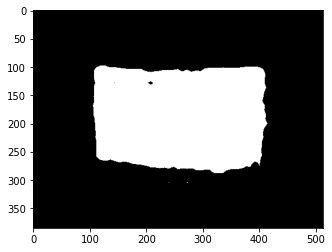

In [18]:
plt.imshow(tv_no_tv_mapping)

In [19]:

np.unique(tv_no_tv_mapping)  #unique intensities value will be 0 and 255 ie black and white


array([  0, 255], dtype=uint8)

3B:Resize tv_no_tv_mapping to original image Resolution

In [20]:
##coverting original image into numpy array
orig_imginal = Image.open(IMAGE_NAME)
orig_imginal = np.array(orig_imginal)

In [21]:
orig_imginal.shape  #shape of original image

(278, 370, 3)

3C:Resizing "tv_no_tv_mapping" image with the same size as original image

In [22]:
#sets shape of mapping_resiszed same as tv_no_tv_mapping
mapping_resized = cv2.resize(tv_no_tv_mapping, 
                             (orig_imginal.shape[1],
                              orig_imginal.shape[0]),
                             Image.ANTIALIAS)

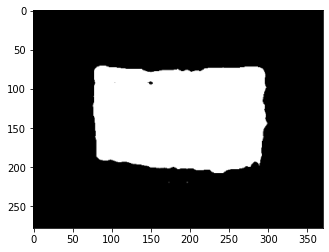

In [23]:
plt.imshow(mapping_resized)

In [ ]:
np.unique(mapping_resized)  ##the range of the resize image is between 0 to 255
##this will cause a problem if we go forward with this entire pixel intenssity value
##binarisation shoild be done


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  21,  22,  23,  24,  25,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  39,  43,  44,  46,  48,  53,  54,  55,
        56,  57,  60,  62,  63,  65,  66,  67,  68,  69,  71,  72,  74,
        75,  77,  79,  80,  81,  83,  84,  86,  87,  89,  92,  94,  95,
        96,  97,  99, 101, 103, 104, 106, 111, 113, 114, 115, 116, 117,
       121, 123, 125, 127, 128, 132, 133, 137, 139, 141, 143, 144, 148,
       150, 151, 152, 153, 154, 156, 160, 161, 162, 164, 165, 166, 170,
       171, 172, 173, 176, 177, 184, 185, 188, 189, 190, 191, 192, 195,
       197, 199, 200, 202, 203, 205, 206, 208, 209, 210, 211, 212, 214,
       218, 219, 222, 223, 224, 225, 226, 229, 231, 232, 233, 235, 236,
       237, 239, 240, 241, 242, 243, 244, 245, 247, 249, 250, 251, 253,
       254, 255], dtype=uint8)

3D:Otsu's Binarization


In [24]:
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray,(15,15),0)
ret3,thresholded_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

##for every pixel greater than treshhold it will be white pixel otherwise black pixel
##rather than selecting binarization value manually otsu give best tresholding value 

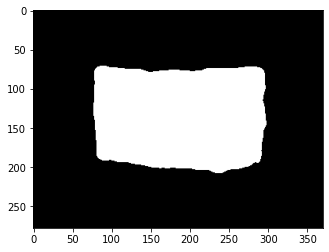

In [25]:
plt.imshow(thresholded_img, cmap="gray") 

In [26]:
thresholded_img.ndim ##dimension of treshold image will have 2 dimensions black and white

2

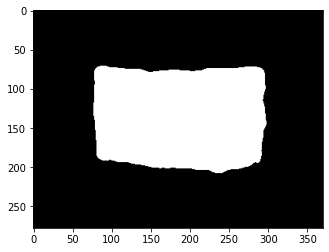

In [27]:
mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB)
plt.imshow(mapping)

In [28]:
np.unique(mapping)

array([  0, 255], dtype=uint8)

3E: Checking if shapes of the mapped image matches to the original image 

In [29]:
mapping_resized.shape #shape of mapping_resized


(278, 370, 3)

In [30]:
orig_imginal.shape ##shape of mapping_resized orig_imginal

(278, 370, 3)

# **4.Put an Image background**

I have selected this to be background of an image


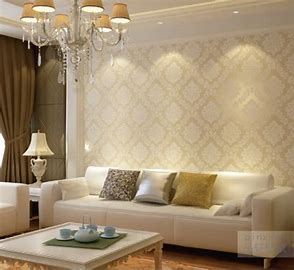

In [38]:
background_image=Image.open("/content/drive/MyDrive/Untitled folder/OIP (3).jpeg")

In [39]:

background_image = np.array(background_image) ##converting it into nparray

In [40]:
background_image.shape #shape of background_image


(270, 294, 3)

4B:Resizng the size of background image same as out mapped and original image

In [44]:
background_image_resized = cv2.resize(background_image, (370,278), interpolation = cv2.INTER_NEAREST)

#resizing same as original image using inter_nearest interpolation

In [42]:
background_image_resized.shape
#resized shape

(278, 370, 3)

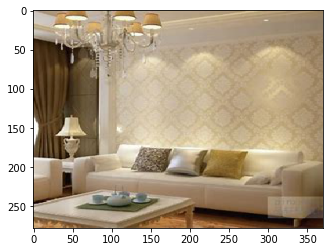

In [43]:
plt.imshow(background_image_resized)

# **5.Add blur/bokeh in the background image to make it look good**

In [45]:
blurred_background_image = cv2.GaussianBlur(background_image_resized,
                                          (251,251), 
                                          2)  ##blurring the background of an image using gaussian blur

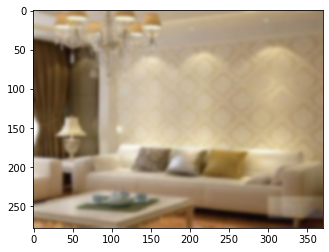

In [47]:
plt.imshow(blurred_background_image)


# **6.Test the image**

6A:Applying Layers


In [49]:
output_image = np.where(mapping != (0,0,0), 
                         orig_imginal, 
                         blurred_background_image)  ##if in segmentation map array,black pixel is there then it will fill the same pixel with blurred_background_image 

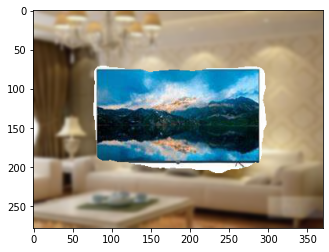

In [50]:
plt.imshow(output_image)

6B:Saving Image

In [51]:
im_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
cv2.imwrite("final_image.jpg", im_rgb)  ##Saving

True

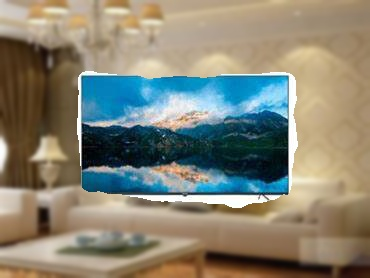

In [52]:
IMG("final_image.jpg") ##o/p of image with blurred background